In [1]:
# V 1.13
# Standard Imports
import pandas as pd
import numpy as np
from zipfile import ZipFile

# Plotting 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from bokeh.plotting import figure, output_notebook, show, output_file
import seaborn as sns

output_notebook()
%matplotlib inline

# Pandas Setup
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

# Colour Management
MC = '#242a49'  # Main
SC = '#ededed'  # Secondary
TC = 'red'  # Tertiary 

colors = ['#202540', '#17b5ff', 'red', 'pink', '#443857', '#bed6f7', '#144c4a']
cmap = mcolors.LinearSegmentedColormap.from_list('n', ['red', 'white', MC])
cmap2 = mcolors.LinearSegmentedColormap.from_list('n', ['white', MC])
boxplot_params = dict(
    patch_artist=True,
    boxprops=dict(facecolor=SC, color=MC),
    capprops=dict(color=MC, linewidth=2),
    whiskerprops=dict(color=MC),
    flierprops=dict(color=MC, markeredgecolor=MC),
    medianprops=dict(color='red', linewidth=2),
)

# Pyplot Setup
plt.rcParams.update({
    'font.family': 'monospace',
    'font.size': 10,
    'figure.figsize': (12, 6),
    'grid.color': SC,
    'axes.titlesize': 16.0,
    'axes.facecolor': 'none',
    'axes.formatter.useoffset': False,  # Scientific notation
})


Loading BokehJS ...

In [2]:
# Additional imports
from bokeh.layouts import layout, widgetbox
from bokeh.models import ColumnDataSource, HoverTool, BoxZoomTool, ResetTool, PanTool
from bokeh.models.widgets import Slider, Select, TextInput, Div
from bokeh.models import WheelZoomTool, SaveTool, LassoSelectTool
from bokeh.io import curdoc
from functools import lru_cache

In [3]:
df = pd.read_csv(ZipFile('data/wine.zip').open('winemag-data-130k-v2.csv'), index_col=0)
df.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,nan,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.00,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.00,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [4]:
df.shape

(129971, 13)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [6]:
[x.title() for x in df.columns]

['Country',
 'Description',
 'Designation',
 'Points',
 'Price',
 'Province',
 'Region_1',
 'Region_2',
 'Taster_Name',
 'Taster_Twitter_Handle',
 'Title',
 'Variety',
 'Winery']

In [7]:
new_cols = ['Country',
 'Description',
 'Designation',
 'Points',
 'Price',
 'Province',
 'Region1',
 'Region2',
 'TasterName',
 'TasterTwitterHandle',
 'Title',
 'Variety',
 'Winery']

In [8]:
df.columns = new_cols

In [9]:
df.Country.value_counts()

US                        54504
France                    22093
Italy                     19540
Spain                      6645
Portugal                   5691
Chile                      4472
Argentina                  3800
Austria                    3345
Australia                  2329
Germany                    2165
New Zealand                1419
South Africa               1401
Israel                      505
Greece                      466
Canada                      257
Hungary                     146
Bulgaria                    141
Romania                     120
Uruguay                     109
Turkey                       90
Slovenia                     87
Georgia                      86
England                      74
Croatia                      73
Mexico                       70
Moldova                      59
Brazil                       52
Lebanon                      35
Morocco                      28
Peru                         16
Ukraine                      14
Macedoni

In [10]:
df.duplicated('Description').sum()

10016

In [11]:
df = df.drop_duplicates('Description')

In [20]:
df.dropna(subset=['Price'], inplace=True)

In [31]:
df[['Price', 'Points']].corr()['Price']

Price    1.00
Points   0.42
Name: Price, dtype: float64

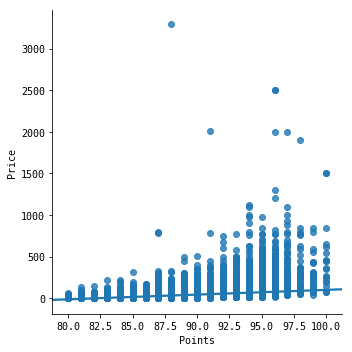

In [34]:
sns.lmplot(y='Price', x='Points', data=df);

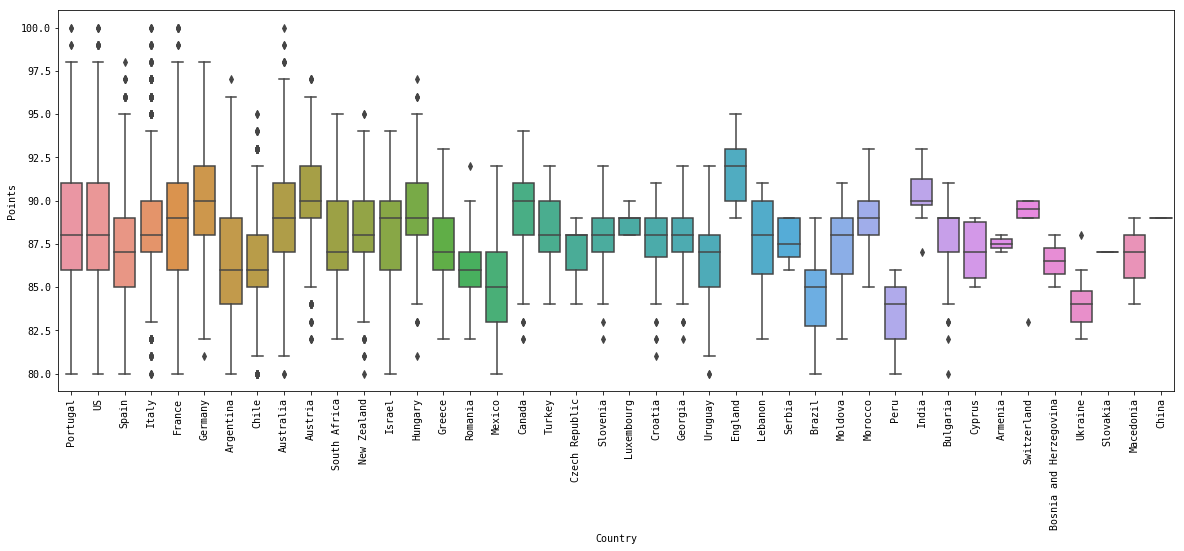

In [36]:
plt.figure(figsize=(20, 7))
sns.boxplot(x='Country', y='Points', data=df)
plt.xticks(rotation=90);

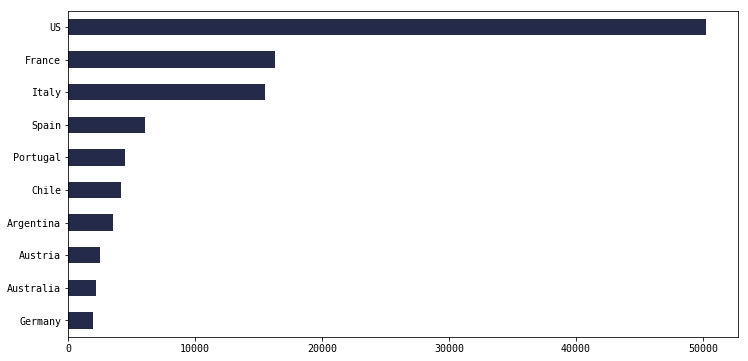

In [39]:
df.Country.value_counts()[:10].sort_values().plot(kind='barh', color=MC);

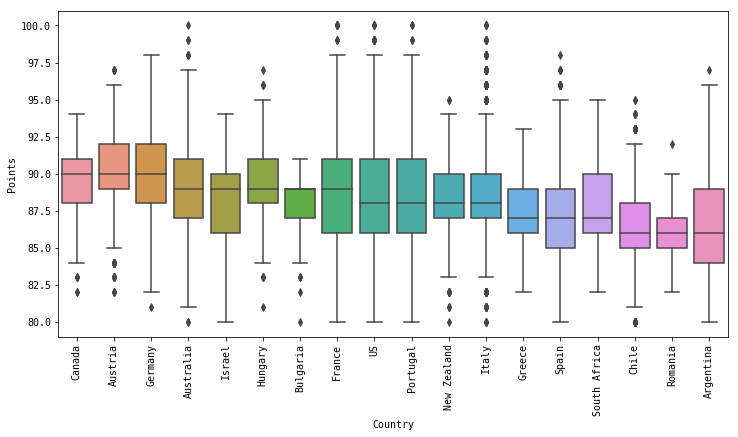

In [59]:
country = df.groupby('Country').filter(lambda x: len(x) > 100)
df2 = pd.DataFrame({col: values['Points'] for col, values in country.groupby('Country')})
medians2 = df2.median()

medians2.sort_values(ascending=False, inplace=True)
sns.boxplot(x='Country', y='Points', data=country, order=medians2.index)
plt.xticks(rotation=90);

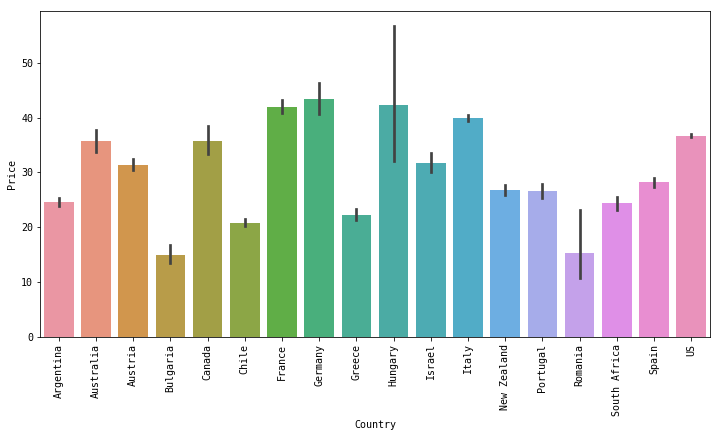

In [60]:
df3 = pd.DataFrame({col: values['Price'] for col, values in country.groupby('Country')})
medians2 = df3.median()

medians.sort_values(ascending=False, inplace=True)
sns.barplot(x='Country', y='Price', data=country, order=medians2.index)
plt.xticks(rotation=90);